In [1]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 47.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=8fcbb48202a89a1bcd19dad028b336efabddbe3e5b24b17c74d11915c3413ca6
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess


In [2]:
import chess
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from typing import List, Tuple
import torch.optim as optim
import time
from tqdm import tqdm

seed = 123456
np.random.seed(seed=seed)

In [3]:
data = pd.read_csv("/kaggle/input/fens-training-set/fens_training_set.csv")

In [4]:
data.shape

(268550, 2)

# Проведём EDA


In [5]:
def validate_fen(fen):
    try:
        board = chess.Board(fen)
        return True
    except:
        return False

In [6]:
data["fen_valid"] = data["fen"].apply(validate_fen)
print(f"Валидных FEN: {data['fen_valid'].sum()}/{len(data)}")

Валидных FEN: 268550/268550


In [7]:
def analyze_fen_structure(fen):
    board = chess.Board(fen)
    return {
        "piece_count": len(board.piece_map()),
        "white_to_move": board.turn,
        "castling_rights": board.castling_rights,
        "en_passant_possible": board.ep_square is not None,
        "halfmove_clock": board.halfmove_clock,
        "fullmove_number": board.fullmove_number,
    }

In [8]:
fen_analysis = data[data["fen_valid"]]["fen"].apply(analyze_fen_structure)

In [9]:
fen_df = pd.DataFrame(fen_analysis.tolist())

In [10]:
print(f"Позиций где ход белых: {(fen_df['white_to_move'] == True).sum()}")
print(f"Позиций где ход черных: {(fen_df['white_to_move'] == False).sum()}")

Позиций где ход белых: 268550
Позиций где ход черных: 0


In [11]:
def analyze_move(move_uci, fen):
    """Детальный анализ хода"""
    try:
        board = chess.Board(fen)
        move = chess.Move.from_uci(move_uci)

        # Проверка легальности хода
        is_legal = move in board.legal_moves

        # Тип хода
        move_types = []
        if board.is_capture(move):
            move_types.append("capture")
        if board.is_castling(move):
            move_types.append("castling")
        if board.is_en_passant(move):
            move_types.append("en_passant")
        if move.promotion:
            move_types.append("promotion")
        if not move_types:
            move_types.append("quiet")

        # Фигура, которая ходит
        piece = board.piece_at(move.from_square)
        piece_type = piece.symbol().upper() if piece else None

        # Расстояние хода
        from_row, from_col = move.from_square // 8, move.from_square % 8
        to_row, to_col = move.to_square // 8, move.to_square % 8
        distance = np.sqrt((from_row - to_row) ** 2 + (from_col - to_col) ** 2)

        return {
            "is_legal": is_legal,
            "move_types": move_types,
            "piece_type": piece_type,
            "move_distance": distance,
            "is_check": board.gives_check(move),
        }
    except:
        return {
            "is_legal": False,
            "move_types": [],
            "piece_type": None,
            "move_distance": 0,
            "is_check": False,
        }

In [12]:
move_analysis = data.apply(lambda row: analyze_move(row["move"], row["fen"]), axis=1)
move_df = pd.DataFrame(move_analysis.tolist())

In [13]:
print(f"Легальных ходов: {move_df['is_legal'].sum()}/{len(move_df)}")
print(f"Ходов, объявляющих шах: {move_df['is_check'].sum()}")

Легальных ходов: 268549/268550
Ходов, объявляющих шах: 22601


In [14]:
move_df[move_df["is_legal"] == False]

,is_legal,move_types,piece_type,move_distance,is_check
232329,False,[castling],K,2.0,True


In [15]:
# Непонятно, почему посчитало нелегальным ходом
data.iloc[move_df[move_df["is_legal"] == False].index]

,fen,move,fen_valid
232329,1r2qk1r/ppb3pb/2p1P3/4p2p/4n3/1P1N3P/P1P3PB/1R...,f1h1,True


In [16]:
data.iloc[move_df[move_df["is_check"] == True].index]

,fen,move,fen_valid
4,rnbqkb1r/pp3ppp/5n2/3p4/2pP4/3B1N2/PPP2PPP/RNB...,f1e1,True
14,8/8/3r4/1pp1p2R/p2k4/P1p5/2B5/2K5 w - - 0 1,h5h4,True
16,r3k3/5p1p/1pp1n2r/p1p1PRp1/2PbN3/P6P/1PP3P1/R6...,e4d6,True
24,r1b2rk1/1p3n1R/p3p1p1/2q2pN1/8/2N4Q/PPP2PP1/2K...,h7h8,True
27,7r/R7/P3p3/1P1k4/2p5/4B2p/7b/2K5 w - - 0 1,a7d7,True
...,...,...,...
268509,rn1qkb1r/ppp1pppp/3p4/4Pb2/1nPP4/5N2/PP3PPP/RN...,d1a4,True
268514,r5k1/1p1n1ppn/1qr5/4p1N1/pBPb4/P4Q2/1P3PPP/1R1...,f3f7,True
268541,3rr3/1pR1b2p/p3QBpk/8/8/q4P2/5KPP/7R w - - 0 1,e6h3,True
268543,2rqnrk1/1p1b1pb1/p2p1Pp1/3N2Pp/2PpP3/1P1Q3P/P1...,d5e7,True


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Text(0.5, 1.0, 'Распределение типов ходов (логарифмический масштаб)')

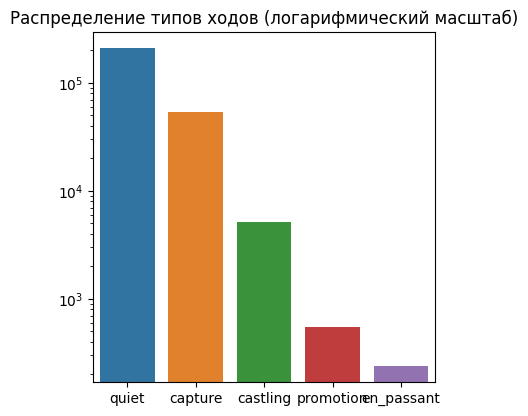

In [17]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
all_move_types = [
    item for sublist in move_df["move_types"].dropna() for item in sublist
]
move_type_counts = Counter(all_move_types)
sns.barplot(y=list(move_type_counts.values()), x=list(move_type_counts.keys()))
plt.yscale("log")
plt.title("Распределение типов ходов (логарифмический масштаб)")

Text(0.5, 1.0, 'Фигуры, совершающие ходы')

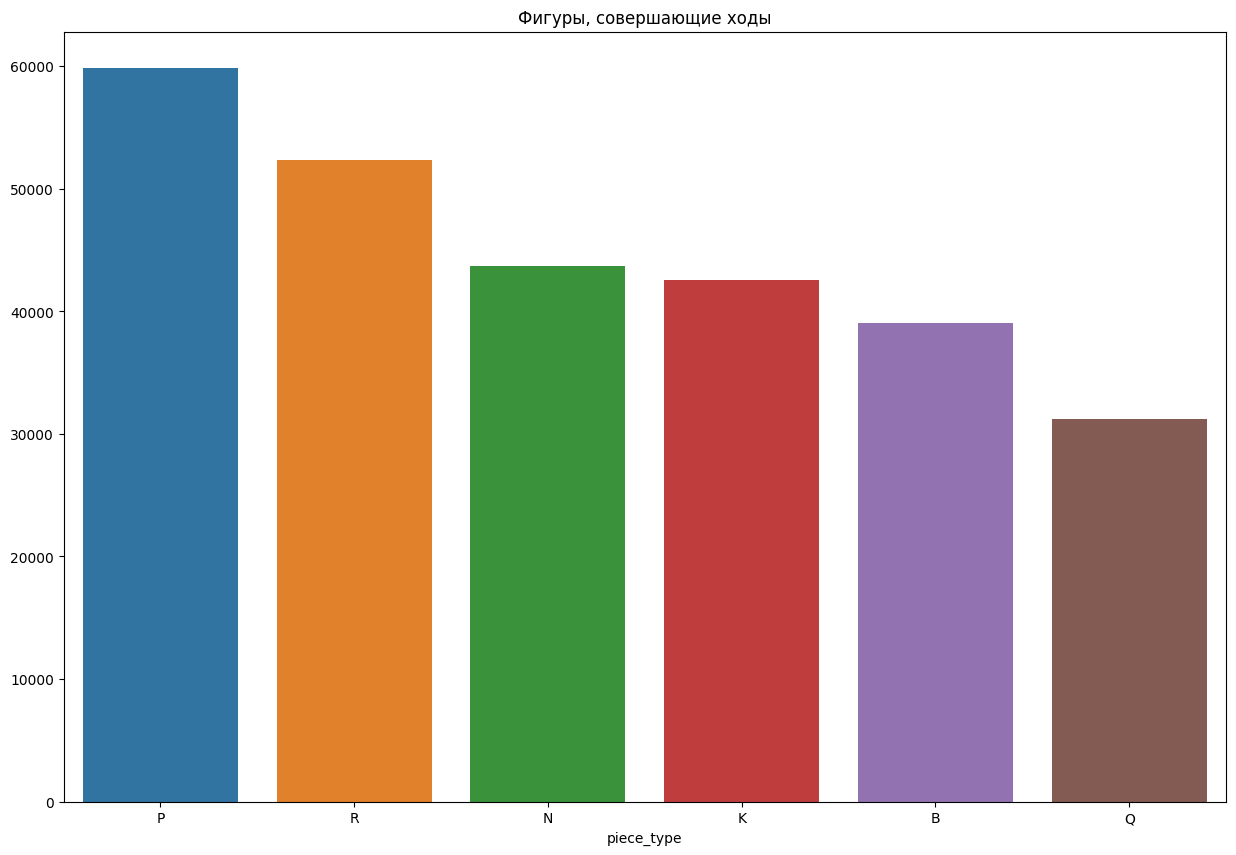

In [18]:
plt.figure(figsize=(15, 10))
piece_counts = move_df["piece_type"].value_counts()
sns.barplot(y=piece_counts.values, x=piece_counts.index)
plt.title("Фигуры, совершающие ходы")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Text(0.5, 0, 'Количество фигур')

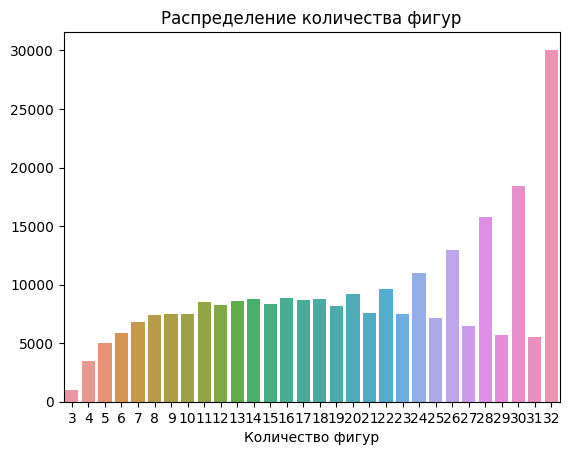

In [19]:
# all_nums_figures_types = [
#     item for sublist in fen_df["piece_count"].dropna() for item in sublist
# ]
nums_figures_counts = Counter(fen_df["piece_count"])
sns.barplot(y=list(nums_figures_counts.values()), x=list(nums_figures_counts.keys()))
plt.title("Распределение количества фигур")
plt.xlabel("Количество фигур")

In [20]:
def analyze_tactical_patterns(fen, move_uci):
    board = chess.Board(fen)
    move = chess.Move.from_uci(move_uci)

    patterns = []

    # Атака на короля
    if board.is_check():
        patterns.append("check")

    # Связка
    for square in chess.SQUARES:
        if board.is_pinned(board.turn, square):
            patterns.append("pin")
            break

    # Двойной удар
    board.push(move)
    attacked_squares = len(
        [sq for sq in chess.SQUARES if board.is_attacked_by(board.turn, sq)]
    )
    board.pop()

    # Взятие фигур
    if board.is_capture(move):
        captured_piece = board.piece_at(move.to_square)
        if captured_piece:
            patterns.append(f"capture_{captured_piece.symbol().upper()}")

    return patterns

In [21]:
# Анализ тактических паттернов
data["tactical_patterns"] = data.apply(
    lambda row: analyze_tactical_patterns(row["fen"], row["move"]), axis=1
)

# Анализ частоты тактических паттернов
all_patterns = [item for sublist in data["tactical_patterns"] for item in sublist]
pattern_counts = Counter(all_patterns)

print("Топ тактических паттернов:")
for pattern, count in pattern_counts.most_common(10):
    print(f"  {pattern}: {count}")

Топ тактических паттернов:
  pin: 35255
  capture_P: 25655
  check: 19590
  capture_N: 9021
  capture_B: 8570
  capture_R: 6390
  capture_Q: 4057


# Разработка модели


In [27]:
class DualHeadChessDataset(Dataset):
    def __init__(self, csv_file: str):
        self.df = pd.read_csv(csv_file)

        self._validate_data()
        self.piece_to_idx = {
            "P": 0,
            "N": 1,
            "B": 2,
            "R": 3,
            "Q": 4,
            "K": 5,
            "p": 6,
            "n": 7,
            "b": 8,
            "r": 9,
            "q": 10,
            "k": 11,
        }

    def _validate_data(self):
        valid_indices = []
        for idx, row in self.df.iterrows():
            try:
                board = chess.Board(row["fen"])
                move = chess.Move.from_uci(row["move"])
                if move in board.legal_moves:
                    valid_indices.append(idx)
            except:
                continue

        self.df = self.df.loc[valid_indices].reset_index(drop=True)
        print(f"Загружено {len(self.df)} валидных позиций")

    def _board_to_tensor(self, fen: str) -> torch.Tensor:
        board = chess.Board(fen)
        tensor = torch.zeros(20, 8, 8, dtype=torch.float32)

        # Фигуры (плоскости 0-11)
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                row, col = square // 8, square % 8
                piece_idx = self.piece_to_idx[piece.symbol()]
                tensor[piece_idx, row, col] = 1.0

        # Чей ход (плоскость 12)
        tensor[12] = 1.0 if board.turn else 0.0

        # Рокировки (плоскости 13-16)
        castling_rights = [
            board.has_kingside_castling_rights(chess.WHITE),
            board.has_queenside_castling_rights(chess.WHITE),
            board.has_kingside_castling_rights(chess.BLACK),
            board.has_queenside_castling_rights(chess.BLACK),
        ]
        for i, has_right in enumerate(castling_rights):
            if has_right:
                tensor[13 + i] = 1.0

        # Взятие на проходе (плоскость 17)
        if board.ep_square is not None:
            row, col = board.ep_square // 8, board.ep_square % 8
            tensor[17, row, col] = 1.0

        # Счетчик полуходов (плоскость 18)
        tensor[18] = board.halfmove_clock / 50.0

        # Номер хода (плоскость 19)
        tensor[19] = board.fullmove_number / 500.0

        return tensor

    def _move_to_dual_labels(self, move_uci: str, fen: str) -> tuple:
        board = chess.Board(fen)
        move = chess.Move.from_uci(move_uci)

        from_square = move.from_square

        # Для to_square учитываем превращения
        # ДИАПАЗОН ДОЛЖЕН БЫТЬ 0-67 (68 классов)
        # print(move.promotion)
        if move.promotion:
            # Кодируем превращения: 64-68
            to_square = 64 + (move.promotion - 1)  # 64, 65, 66, 67, 68
        else:
            to_square = move.to_square  # 0-63

        # Проверяем, что to_square в правильном диапазоне
        if to_square >= 69:
            raise ValueError(f"Некорректный to_square: {to_square} для хода {move_uci}")

        return from_square, to_square

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fen = row["fen"]
        move = row["move"]

        board_tensor = self._board_to_tensor(fen)
        from_label, to_label = self._move_to_dual_labels(move, fen)

        return board_tensor, from_label, to_label

In [22]:
class ChessDataSplitter:
    def __init__(
        self,
        csv_file,
        train_ratio=0.7,
        val_ratio=0.15,
        test_ratio=0.15,
        random_state=42,
    ):
        print(train_ratio, val_ratio, test_ratio)
        assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, (
            "Сумма долей должна быть равна 1"
        )

        self.csv_file = csv_file
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.random_state = random_state

        # Загружаем полный dataset
        self.full_dataset = DualHeadChessDataset(csv_file)

    def split_data(self):
        """Разбивает данные на train/val/test"""
        # Получаем индексы
        n_total = len(self.full_dataset)
        indices = list(range(n_total))

        # Первое разбиение: отделяем test
        train_val_idx, test_idx = train_test_split(
            indices,
            test_size=self.test_ratio,
            random_state=self.random_state,
            shuffle=True,
        )

        # Второе разбиение: разделяем train и val
        train_idx, val_idx = train_test_split(
            train_val_idx,
            test_size=self.val_ratio / (self.train_ratio + self.val_ratio),
            random_state=self.random_state,
            shuffle=True,
        )

        # Создаем Subset datasets
        train_dataset = Subset(self.full_dataset, train_idx)
        val_dataset = Subset(self.full_dataset, val_idx)
        test_dataset = Subset(self.full_dataset, test_idx)

        print(f"Разбиение завершено:")
        print(
            f"Train: {len(train_dataset)} samples ({len(train_dataset) / n_total * 100:.1f}%)"
        )
        print(
            f"Val: {len(val_dataset)} samples ({len(val_dataset) / n_total * 100:.1f}%)"
        )
        print(
            f"Test: {len(test_dataset)} samples ({len(test_dataset) / n_total * 100:.1f}%)"
        )

        return train_dataset, val_dataset, test_dataset

In [23]:
class DualHeadChessModel(nn.Module):
    def __init__(self, device="cpu"):
        super().__init__()
        self.device = device

        # Общая CNN основа (backbone)
        self.conv1 = nn.Conv2d(20, 128, 3, padding=1)
        self.conv2 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3 = nn.Conv2d(256, 512, 3, padding=1)

        # Голова для предсказания исходной клетки (64 клетки)
        self.from_fc1 = nn.Linear(512 * 8 * 8, 256)
        self.from_output = nn.Linear(256, 64)

        # Голова для предсказания целевой клетки (64 клетки + 5 превращения = 69)
        self.to_conv = nn.Conv2d(
            512 + 64, 256, 3, padding=1
        )  # +64 для эмбеддинга исходной клетки
        self.to_fc1 = nn.Linear(256 * 8 * 8, 128)
        self.to_output = nn.Linear(128, 69)

    def forward(self, board_tensor, from_square=None):
        # Общие признаки
        x = F.relu(self.conv1(board_tensor))
        x = F.relu(self.conv2(x))
        shared_features = F.relu(self.conv3(x))

        # Вероятности для исходной клетки
        from_flat = shared_features.view(shared_features.size(0), -1)
        from_hidden = F.relu(self.from_fc1(from_flat))
        from_probs = F.softmax(self.from_output(from_hidden), dim=1)

        if from_square is None:
            # Режим обучения - возвращаем обе головы
            return from_probs, None

        # Вероятности для целевой клетки (условные на исходной клетке)
        from_onehot = torch.zeros(shared_features.size(0), 64, 8, 8)
        from_onehot[torch.arange(shared_features.size(0)), from_square, :, :] = 1

        # Объединяем общие признаки с информацией об исходной клетке
        shared_features, from_onehot = shared_features.to(self.device), from_onehot.to(self.device)
        to_input = torch.cat([shared_features, from_onehot], dim=1).to(self.device)
        to_features = F.relu(self.to_conv(to_input))

        to_flat = to_features.view(to_features.size(0), -1).to(self.device)
        to_hidden = F.relu(self.to_fc1(to_flat))
        to_probs = F.softmax(self.to_output(to_hidden), dim=1)

        return from_probs, to_probs

In [24]:
class ChessTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device="cpu"):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device

        # Функции потерь
        self.from_criterion = nn.CrossEntropyLoss()
        self.to_criterion = nn.CrossEntropyLoss()

        # Оптимизатор
        self.optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)

        # Планировщик learning rate
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode="min", factor=0.5, patience=10
        )

        # История обучения
        self.history = {
            "train_loss": [],
            "val_loss": [],
            "train_from_acc": [],
            "val_from_acc": [],
            "train_to_acc": [],
            "val_to_acc": [],
            "learning_rate": [],
        }

    def train_epoch(self):
        """Одна эпоха обучения"""
        self.model.train()
        total_loss = 0
        total_from_correct = 0
        total_to_correct = 0
        total_samples = 0

        train_bar = tqdm(self.train_loader, desc="Training")

        for batch_idx, (boards, from_targets, to_targets) in enumerate(train_bar):
            # Перемещаем данные на device
            boards = boards.to(self.device)
            from_targets = from_targets.to(self.device)
            to_targets = to_targets.to(self.device)

            # Обнуляем градиенты
            self.optimizer.zero_grad()

            # Прямой проход
            from_probs, to_probs = self.model(boards, from_targets)

            # Вычисляем потери
            # print(to_probs, to_targets)
            from_loss = self.from_criterion(from_probs, from_targets)
            to_loss = self.to_criterion(to_probs, to_targets)
            loss = from_loss + to_loss

            # Обратный проход
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            # Шаг оптимизатора
            self.optimizer.step()

            # Статистика
            total_loss += loss.item()
            batch_size = boards.size(0)
            total_samples += batch_size

            # Точность для from-square
            from_preds = torch.argmax(from_probs, dim=1)
            from_correct = (from_preds == from_targets).sum().item()
            total_from_correct += from_correct

            # Точность для to-square
            to_preds = torch.argmax(to_probs, dim=1)
            to_correct = (to_preds == to_targets).sum().item()
            total_to_correct += to_correct

            # Обновляем progress bar
            train_bar.set_postfix(
                {
                    "Loss": f"{loss.item():.4f}",
                    "From Acc": f"{from_correct / batch_size:.3f}",
                    "To Acc": f"{to_correct / batch_size:.3f}",
                }
            )

        # Вычисляем средние метрики за эпоху
        avg_loss = total_loss / len(self.train_loader)
        from_acc = total_from_correct / total_samples
        to_acc = total_to_correct / total_samples

        return avg_loss, from_acc, to_acc

    def validate(self):
        """Валидация модели"""
        self.model.eval()
        total_loss = 0
        total_from_correct = 0
        total_to_correct = 0
        total_samples = 0

        with torch.no_grad():
            for boards, from_targets, to_targets in tqdm(
                self.val_loader, desc="Validation"
            ):
                boards = boards.to(self.device)
                from_targets = from_targets.to(self.device)
                to_targets = to_targets.to(self.device)

                # Прямой проход
                from_probs, to_probs = self.model(boards, from_targets)

                # Потери
                from_loss = self.from_criterion(from_probs, from_targets)
                to_loss = self.to_criterion(to_probs, to_targets)
                loss = from_loss + to_loss

                total_loss += loss.item()
                batch_size = boards.size(0)
                total_samples += batch_size

                # Точность
                from_preds = torch.argmax(from_probs, dim=1)
                from_correct = (from_preds == from_targets).sum().item()
                total_from_correct += from_correct

                to_preds = torch.argmax(to_probs, dim=1)
                to_correct = (to_preds == to_targets).sum().item()
                total_to_correct += to_correct

        avg_loss = total_loss / len(self.val_loader)
        from_acc = total_from_correct / total_samples
        to_acc = total_to_correct / total_samples

        return avg_loss, from_acc, to_acc

    def train(self, num_epochs=50, early_stopping_patience=10):
        """Полный цикл обучения"""
        best_val_loss = float("inf")
        patience_counter = 0

        print("Начало обучения...")
        print(f"Используется устройство: {self.device}")
        print(f"Размер тренировочного набора: {len(self.train_loader.dataset)}")
        print(f"Размер валидационного набора: {len(self.val_loader.dataset)}")

        for epoch in range(num_epochs):
            print(f"\nЭпоха {epoch + 1}/{num_epochs}")
            print("-" * 50)

            # Обучение
            train_loss, train_from_acc, train_to_acc = self.train_epoch()

            # Валидация
            val_loss, val_from_acc, val_to_acc = self.validate()

            # Обновление learning rate
            self.scheduler.step(val_loss)
            current_lr = self.optimizer.param_groups[0]["lr"]

            # Сохраняем историю
            self.history["train_loss"].append(train_loss)
            self.history["val_loss"].append(val_loss)
            self.history["train_from_acc"].append(train_from_acc)
            self.history["val_from_acc"].append(val_from_acc)
            self.history["train_to_acc"].append(train_to_acc)
            self.history["val_to_acc"].append(val_to_acc)
            self.history["learning_rate"].append(current_lr)

            # Выводим результаты
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            print(
                f"Train From Acc: {train_from_acc:.4f} | Val From Acc: {val_from_acc:.4f}"
            )
            print(f"Train To Acc: {train_to_acc:.4f} | Val To Acc: {val_to_acc:.4f}")
            print(f"Learning Rate: {current_lr:.6f}")

            # Сохранение лучшей модели
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                self.save_model(f"best_chess_model.pth")
                print("Сохранена лучшая модель!")
            else:
                patience_counter += 1
                print(
                    f"⏳ Early stopping: {patience_counter}/{early_stopping_patience}"
                )

            # Early stopping
            if patience_counter >= early_stopping_patience:
                print("Ранняя остановка!")
                break

        print("\nОбучение завершено!")
        self.plot_training_history()

    def evaluate(self):
        """Финальная оценка на тестовом наборе"""
        print("\nОценка на тестовом наборе...")
        self.model.eval()

        total_from_correct = 0
        total_to_correct = 0
        total_full_correct = 0
        total_samples = 0

        with torch.no_grad():
            for boards, from_targets, to_targets in tqdm(
                self.test_loader, desc="Testing"
            ):
                boards = boards.to(self.device)
                from_targets = from_targets.to(self.device)
                to_targets = to_targets.to(self.device)

                # Предсказание from-square
                from_probs, _ = self.model(boards)
                from_preds = torch.argmax(from_probs, dim=1)

                # Предсказание to-square (используя правильные from-square для честной оценки)
                _, to_probs = self.model(boards, from_targets)
                to_preds = torch.argmax(to_probs, dim=1)

                # Подсчет правильных предсказаний
                from_correct = (from_preds == from_targets).sum().item()
                to_correct = (to_preds == to_targets).sum().item()
                full_correct = (
                    ((from_preds == from_targets) & (to_preds == to_targets))
                    .sum()
                    .item()
                )

                total_from_correct += from_correct
                total_to_correct += to_correct
                total_full_correct += full_correct
                total_samples += boards.size(0)

        from_acc = total_from_correct / total_samples
        to_acc = total_to_correct / total_samples
        full_acc = total_full_correct / total_samples

        print(f"\nРезультаты на тестовом наборе:")
        print(f"From-square Accuracy: {from_acc:.4f}")
        print(f"To-square Accuracy: {to_acc:.4f}")
        print(f"Full Move Accuracy: {full_acc:.4f}")

        return from_acc, to_acc, full_acc

    def save_model(self, path):
        """Сохранение модели"""
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "history": self.history,
            },
            path,
        )

    def load_model(self, path):
        """Загрузка модели"""
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        self.history = checkpoint["history"]

    def plot_training_history(self):
        """Визуализация истории обучения"""
        import matplotlib.pyplot as plt

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        # Потери
        ax1.plot(self.history["train_loss"], label="Train Loss")
        ax1.plot(self.history["val_loss"], label="Val Loss")
        ax1.set_title("Потери")
        ax1.set_xlabel("Эпоха")
        ax1.set_ylabel("Loss")
        ax1.legend()
        ax1.grid(True)

        # From-square точность
        ax2.plot(self.history["train_from_acc"], label="Train From Acc")
        ax2.plot(self.history["val_from_acc"], label="Val From Acc")
        ax2.set_title("From-square Точность")
        ax2.set_xlabel("Эпоха")
        ax2.set_ylabel("Accuracy")
        ax2.legend()
        ax2.grid(True)

        # To-square точность
        ax3.plot(self.history["train_to_acc"], label="Train To Acc")
        ax3.plot(self.history["val_to_acc"], label="Val To Acc")
        ax3.set_title("To-square Точность")
        ax3.set_xlabel("Эпоха")
        ax3.set_ylabel("Accuracy")
        ax3.legend()
        ax3.grid(True)

        # Learning rate
        ax4.plot(self.history["learning_rate"])
        ax4.set_title("Learning Rate")
        ax4.set_xlabel("Эпоха")
        ax4.set_ylabel("LR")
        ax4.grid(True)

        plt.tight_layout()
        plt.savefig("training_history.png", dpi=300, bbox_inches="tight")
        plt.show()

In [25]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Используется устройство: {device}")

    # Загрузка данных
    print("Загрузка данных...")
    splitter = ChessDataSplitter(
        test_ratio=0.01,
        val_ratio=0.2 * (1 - 0.01),
        train_ratio=0.8 * (1 - 0.01),
        csv_file="/kaggle/input/fens-training-set/fens_training_set.csv",
    )
    train_dataset, val_dataset, test_dataset = splitter.split_data()
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

    # Модель
    print("Инициализация модели...")
    model = DualHeadChessModel(device=device)

    # Тренер
    trainer = ChessTrainer(model, train_loader, val_loader, test_loader, device=device)

    # Обучение
    trainer.train(num_epochs=20, early_stopping_patience=10)

    # Валидация
    trainer.validate()

    # # Сохранение финальной модели
    # trainer.save_model("final_chess_model.pth")
    # print("Модель сохранена!")

Используется устройство: cuda
Загрузка данных...
0.792 0.198 0.01
Загружено 268549 валидных позиций
Разбиение завершено:
Train: 212690 samples (79.2%)
Val: 53173 samples (19.8%)
Test: 2686 samples (1.0%)
Инициализация модели...
Начало обучения...
Используется устройство: cuda
Размер тренировочного набора: 212690
Размер валидационного набора: 53173

Эпоха 1/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 64.35it/s]


Train Loss: 8.3793 | Val Loss: 8.3806
Train From Acc: 0.0480 | Val From Acc: 0.0477
Train To Acc: 0.0168 | Val To Acc: 0.0158
Learning Rate: 0.010000
Сохранена лучшая модель!

Эпоха 2/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 64.94it/s]


Train Loss: 8.3793 | Val Loss: 8.3806
Train From Acc: 0.0480 | Val From Acc: 0.0477
Train To Acc: 0.0168 | Val To Acc: 0.0158
Learning Rate: 0.010000
⏳ Early stopping: 1/10

Эпоха 3/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 64.22it/s]


Train Loss: 8.3907 | Val Loss: 8.3963
Train From Acc: 0.0419 | Val From Acc: 0.0386
Train To Acc: 0.0115 | Val To Acc: 0.0092
Learning Rate: 0.010000
⏳ Early stopping: 2/10

Эпоха 4/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 64.62it/s]


Train Loss: 8.3962 | Val Loss: 8.3963
Train From Acc: 0.0388 | Val From Acc: 0.0386
Train To Acc: 0.0091 | Val To Acc: 0.0092
Learning Rate: 0.010000
⏳ Early stopping: 3/10

Эпоха 5/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 63.94it/s]


Train Loss: 8.3962 | Val Loss: 8.3963
Train From Acc: 0.0388 | Val From Acc: 0.0386
Train To Acc: 0.0091 | Val To Acc: 0.0092
Learning Rate: 0.010000
⏳ Early stopping: 4/10

Эпоха 6/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 64.93it/s]


Train Loss: 8.3864 | Val Loss: 8.3579
Train From Acc: 0.0388 | Val From Acc: 0.0386
Train To Acc: 0.0189 | Val To Acc: 0.0476
Learning Rate: 0.010000
Сохранена лучшая модель!

Эпоха 7/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 65.27it/s]


Train Loss: 8.3613 | Val Loss: 8.3626
Train From Acc: 0.0347 | Val From Acc: 0.0339
Train To Acc: 0.0481 | Val To Acc: 0.0476
Learning Rate: 0.010000
⏳ Early stopping: 1/10

Эпоха 8/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 64.35it/s]


Train Loss: 8.3627 | Val Loss: 8.3626
Train From Acc: 0.0333 | Val From Acc: 0.0339
Train To Acc: 0.0481 | Val To Acc: 0.0476
Learning Rate: 0.010000
⏳ Early stopping: 2/10

Эпоха 9/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 64.78it/s]


Train Loss: 8.3627 | Val Loss: 8.3626
Train From Acc: 0.0333 | Val From Acc: 0.0339
Train To Acc: 0.0481 | Val To Acc: 0.0476
Learning Rate: 0.010000
⏳ Early stopping: 3/10

Эпоха 10/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 64.32it/s]


Train Loss: 8.3772 | Val Loss: 8.3785
Train From Acc: 0.0373 | Val From Acc: 0.0390
Train To Acc: 0.0296 | Val To Acc: 0.0266
Learning Rate: 0.010000
⏳ Early stopping: 4/10

Эпоха 11/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 64.86it/s]


Train Loss: 8.3792 | Val Loss: 8.3785
Train From Acc: 0.0385 | Val From Acc: 0.0390
Train To Acc: 0.0264 | Val To Acc: 0.0266
Learning Rate: 0.010000
⏳ Early stopping: 5/10

Эпоха 12/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 64.64it/s]


Train Loss: 8.3898 | Val Loss: 8.3956
Train From Acc: 0.0328 | Val From Acc: 0.0292
Train To Acc: 0.0215 | Val To Acc: 0.0194
Learning Rate: 0.010000
⏳ Early stopping: 6/10

Эпоха 13/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 64.44it/s]


Train Loss: 8.3952 | Val Loss: 8.3889
Train From Acc: 0.0301 | Val From Acc: 0.0317
Train To Acc: 0.0187 | Val To Acc: 0.0212
Learning Rate: 0.010000
⏳ Early stopping: 7/10

Эпоха 14/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 63.94it/s]


Train Loss: 8.3648 | Val Loss: 8.3648
Train From Acc: 0.0313 | Val From Acc: 0.0317
Train To Acc: 0.0480 | Val To Acc: 0.0476
Learning Rate: 0.010000
⏳ Early stopping: 8/10

Эпоха 15/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 64.32it/s]


Train Loss: 8.3512 | Val Loss: 8.3487
Train From Acc: 0.0448 | Val From Acc: 0.0477
Train To Acc: 0.0481 | Val To Acc: 0.0476
Learning Rate: 0.010000
Сохранена лучшая модель!

Эпоха 16/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 64.43it/s]


Train Loss: 8.3481 | Val Loss: 8.3487
Train From Acc: 0.0480 | Val From Acc: 0.0477
Train To Acc: 0.0481 | Val To Acc: 0.0476
Learning Rate: 0.010000
⏳ Early stopping: 1/10

Эпоха 17/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 64.08it/s]


Train Loss: 8.3511 | Val Loss: 8.3565
Train From Acc: 0.0480 | Val From Acc: 0.0477
Train To Acc: 0.0450 | Val To Acc: 0.0398
Learning Rate: 0.010000
⏳ Early stopping: 2/10

Эпоха 18/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 64.58it/s]


Train Loss: 8.3568 | Val Loss: 8.3565
Train From Acc: 0.0480 | Val From Acc: 0.0477
Train To Acc: 0.0393 | Val To Acc: 0.0398
Learning Rate: 0.010000
⏳ Early stopping: 3/10

Эпоха 19/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 63.99it/s]


Train Loss: 8.3568 | Val Loss: 8.3565
Train From Acc: 0.0480 | Val From Acc: 0.0477
Train To Acc: 0.0393 | Val To Acc: 0.0398
Learning Rate: 0.010000
⏳ Early stopping: 4/10

Эпоха 20/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:25<00:00, 64.08it/s]


Train Loss: 8.3628 | Val Loss: 8.3657
Train From Acc: 0.0480 | Val From Acc: 0.0477
Train To Acc: 0.0333 | Val To Acc: 0.0307
Learning Rate: 0.010000
⏳ Early stopping: 5/10

Обучение завершено!


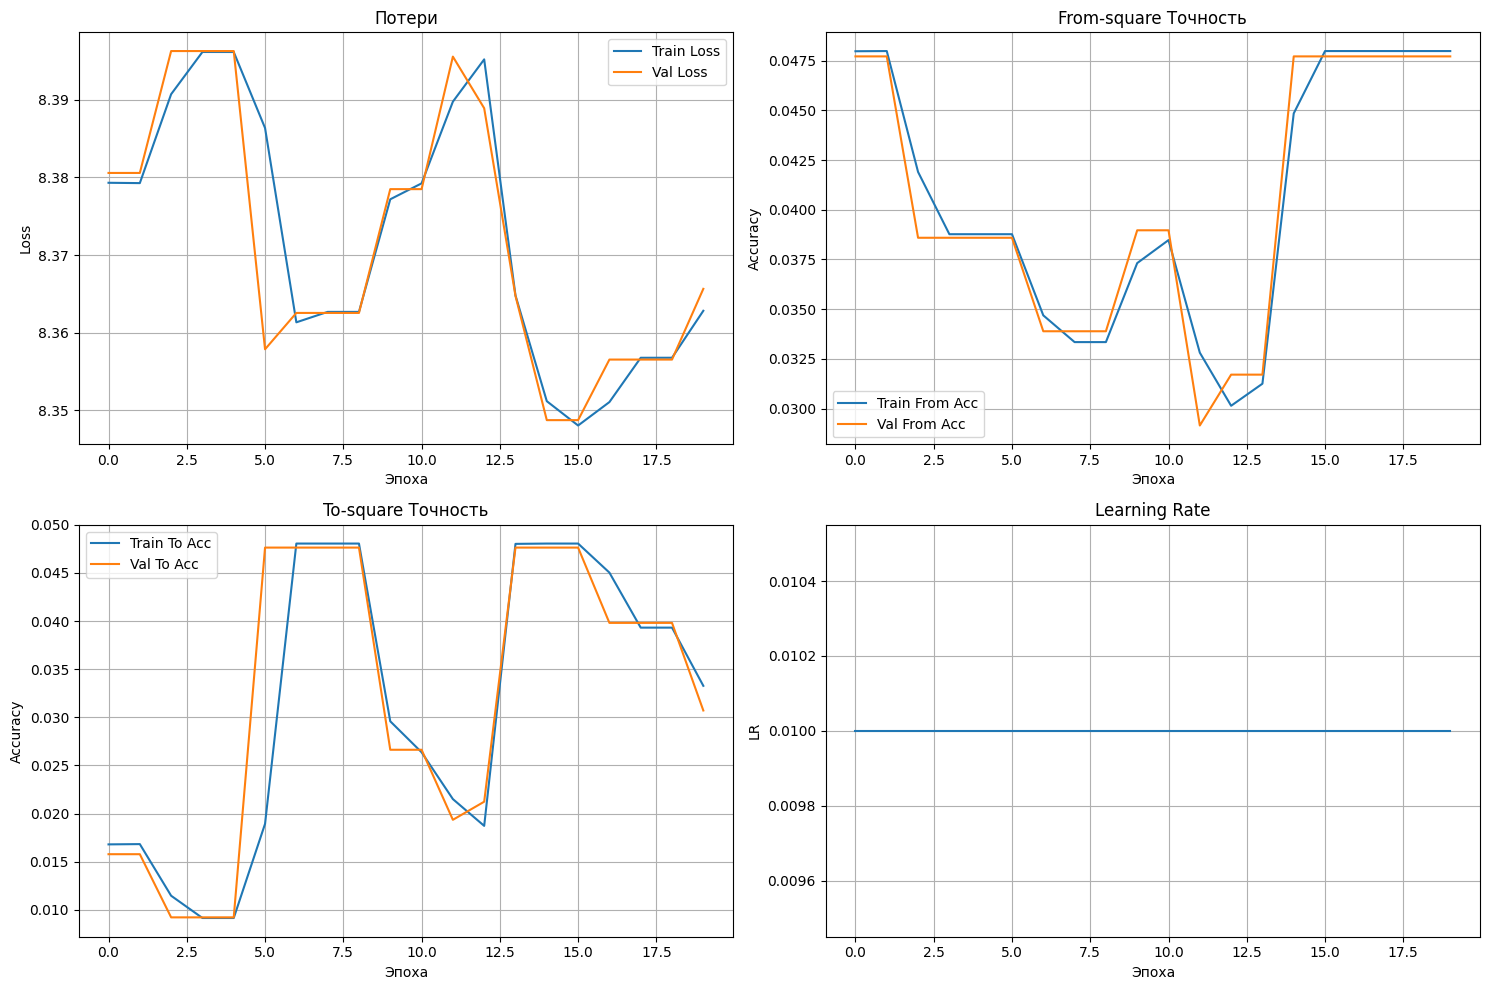

Validation: 100%|██████████| 1662/1662 [00:25<00:00, 64.40it/s]


In [28]:
if __name__ == "__main__":
    main()